# Forecasting AI and ML Job Trends with SARIMA

At this stage, we perform Sentiment and Context Analysis using NLP Techniques

- ***Contextual Skill Analysis***: Uses Named Entity Recognition (NER) to understand how AI skills are described in job postings.
- ***Sentiment Analysis***: Determines employer sentiment around AI skills (e.g., "essential," "preferred") to assess demand urgency.

Model used: **BERT**

## Dependencies

In [1]:
import re
from collections import Counter
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

import geopandas as gpd

/Users/mzitoh/Desktop/USD-Source/data_mining/ai-ml-job-trends/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
filename = "data/b_job_postings_ai_ml_ds.parquet"
ai_ml_jobs = pd.read_parquet(filename)

In [3]:
print(f"{len(ai_ml_jobs):,} job postings loaded from {filename}")
ai_ml_jobs.sample(3)

62,621 job postings loaded from data/b_job_postings_ai_ml_ds.parquet


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,keyword_count,keyword_likelihood
934833,2024-01-19 18:45:13.823004+00,t,t,f,plant controller (client direct hire position),"uhy llp, certified public accountants","kentucky, united states",2024-01-14,kentucky,united states,accountant cost,mid senior,onsite,"[cost accounting, inventory accounting, budget...",27,2,1
540251,2024-01-19 09:45:09.215838+00,t,t,f,power bi developer,peterson technology partners,"northbrook, il",2024-01-13,north chicago,united states,computer systems hardware analyst,mid senior,onsite,"[excel, pivot tables, vlookup, macros, data ag...",18,3,2
460495,2024-01-19 09:45:09.215838+00,t,t,f,business analyst - (payments/swift/jira),verdant infotech solutions,"tampa, fl",2024-01-13,seminole,united states,job analyst,mid senior,onsite,"[data modeling, data analysis, business analys...",15,2,1


## Sentiment Analysis Using BERT

Load pre-trained BERT model for sentiment analysis

In [4]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use mps:0


In [5]:
def combine_row_text(row):
    return f"{row['job_title']} {row['search_position']} {', '.join(row['job_skills'])}".lower()

In [6]:
from tqdm import tqdm

def analyze_sentiment_bert(text):
    max_length = 512
    truncated_text = text[:max_length]
    result = sentiment_analyzer(truncated_text)
    sentiment = result[0]["label"], result[0]["score"]
    # print(f"Sentiment: {sentiment}")
    return sentiment

def add_sentiment_bert(df):
    df = df.copy()
    combined_text = df.apply(lambda row: combine_row_text(row), axis=1)
    sentiments = []
    for desc in tqdm(combined_text, desc="Analyzing Sentiment"):
        sentiments.append(analyze_sentiment_bert(desc))
    df["sentiment_label"], df["sentiment_score"] = zip(*sentiments)
    
    return df

Apply sentiment analysis

In [7]:
start_time = time.time()

ai_ml_jobs_analysed = add_sentiment_bert(ai_ml_jobs)

end_time = time.time()
print(f"Processed {len(ai_ml_jobs_analysed):,} job postings in {end_time - start_time:.0f} seconds")

Analyzing Sentiment: 100%|██████████| 62621/62621 [27:56<00:00, 37.34it/s]  


Processed 62,621 job postings in 1677 seconds


Save analysed jobs

In [8]:
filename_analysed = "data/c_job_postings_ai_ml_sent_analysed.parquet"
ai_ml_jobs_analysed.to_parquet(filename_analysed)

In [9]:
ai_ml_jobs_analysed.head()

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,keyword_count,keyword_likelihood,sentiment_label,sentiment_score
86,2024-01-21 07:43:50.134579+00,t,t,f,optical engineers iv,sts technical services,"san francisco, ca",2024-01-14,richmond,united states,electrical engineer,mid senior,onsite,"[optical design, zemax, fred, optical subassem...",25,2,1,5 stars,0.423902
103,2024-01-21 07:43:52.624477+00,t,t,f,"lead software engineer, back end",clickjobs.io,"poughkeepsie, ny",2024-01-14,new windsor,united states,job development specialist,mid senior,onsite,"[distributed microservices, machine learning o...",11,6,4,5 stars,0.422294
104,2024-01-21 07:43:53.192528+00,t,t,f,"founding fullstack engineer, ai startup",recruiting from scratch,"clearwater, fl",2024-01-14,clearwater,united states,extra,mid senior,onsite,"[software engineering, machine learning, pytho...",30,4,2,5 stars,0.645385
180,2024-01-21 08:08:44.927905+00,t,t,f,"senior software engineer, devops",jobs for humanity,"atlantic city, nj",2024-01-14,ocean city,united states,manager employment,mid senior,onsite,"[devops, cloud native technologies, amazon web...",22,3,2,5 stars,0.477041
182,2024-01-21 08:08:48.031964+00,t,t,f,senior machine learning engineer,jobs for humanity,"new haven, ct",2024-01-14,east haven,united states,agricultural-research engineer,mid senior,onsite,"[machine learning, programming, python, scala,...",27,11,7,4 stars,0.408483


Distribution of sentiment labels

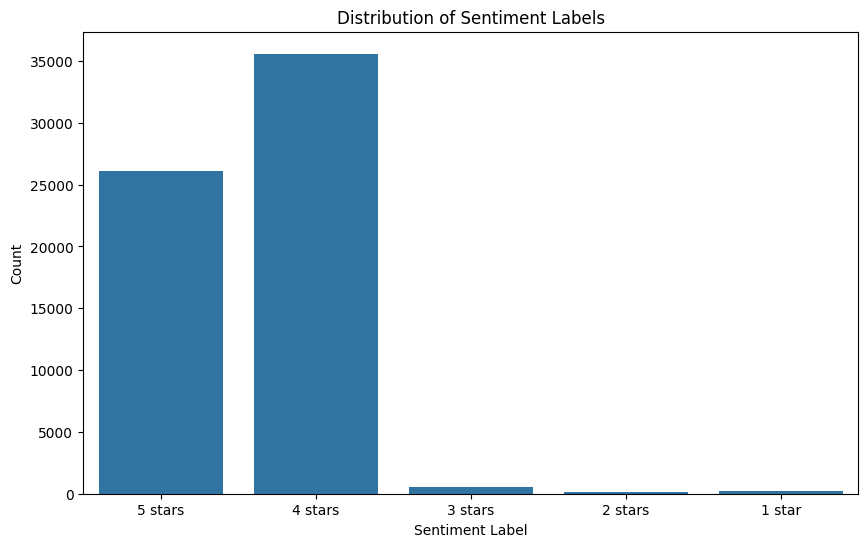

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=ai_ml_jobs_analysed, x='sentiment_label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

Sentiment scores

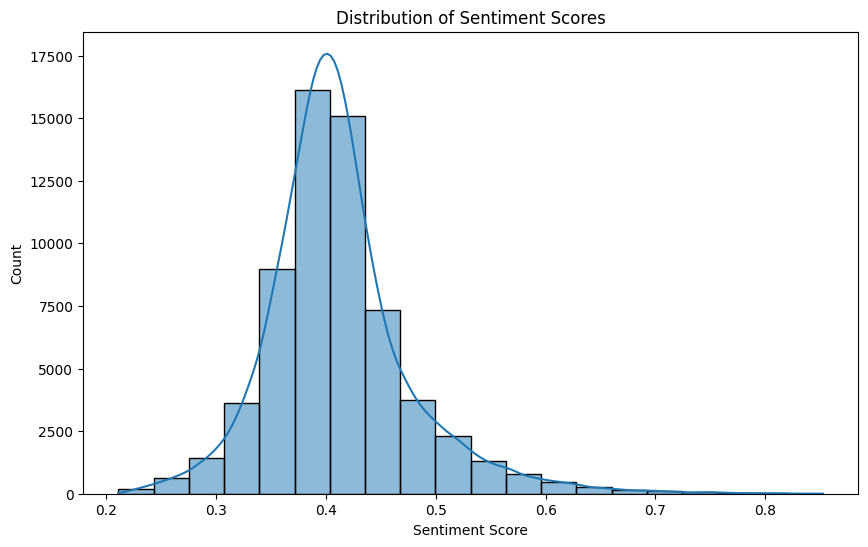

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ai_ml_jobs_analysed, x='sentiment_score', bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

Sentiment by job title

job_title_clean
vehicle condition inspector                                                                0.836589
excellent obgyn hospitalist opening in daytona fl west fl area  great worklife balance     0.822837
product manager enterprise ai                                                              0.817165
cnc machinist                                                                              0.811771
quantitative developer  global prestigious hedge fund  excellent compensation  benefits    0.810632
maximo developer                                                                           0.810627
senior devsecops engineer  1003                                                            0.808057
global senior strategic ai product manager                                                 0.804776
senior software engineer  top hedge fund pw                                                0.800988
lead db developer any db exp  aws                                                   

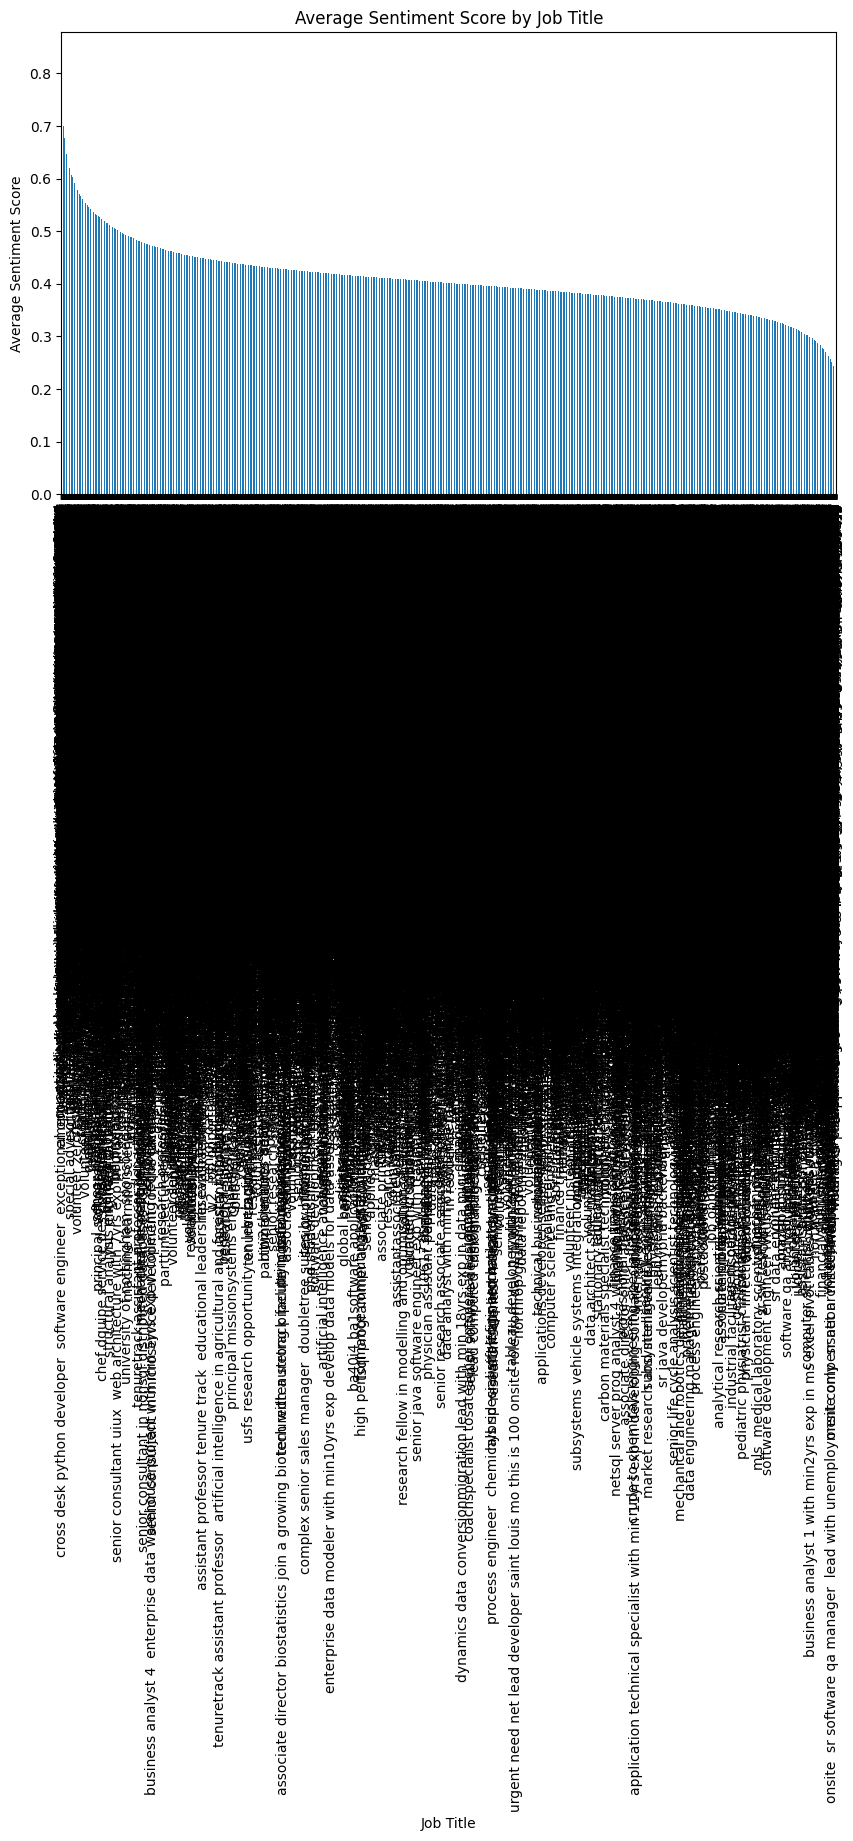

In [22]:
# Clean job titles by removing special characters
ai_ml_jobs_analysed["job_title_clean"] = ai_ml_jobs_analysed["job_title"].str.replace(
    r"[^a-zA-Z0-9\s]", "", regex=True
)

sentiment_by_title = (
    ai_ml_jobs_analysed.groupby("job_title_clean")["sentiment_score"]
    .mean()
    .sort_values(ascending=False)
)
print(sentiment_by_title[:10])

plt.figure(figsize=(10, 6))
sentiment_by_title.plot(kind="bar")
plt.title("Average Sentiment Score by Job Title")
plt.xlabel("Job Title")
plt.ylabel("Average Sentiment Score")
plt.show()

Investigate relationships

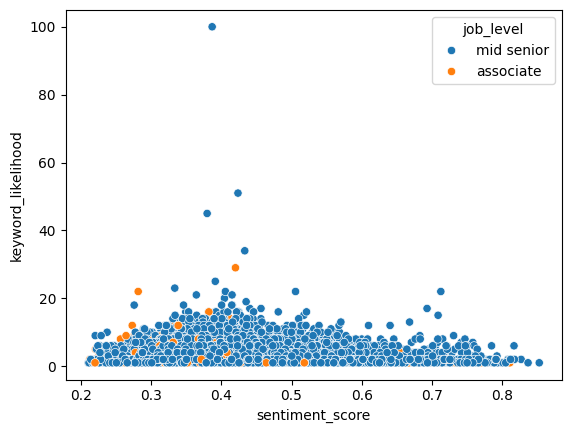

In [13]:
sns.scatterplot(
    x="sentiment_score",
    y="keyword_likelihood",
    hue="job_level",
    data=ai_ml_jobs_analysed,
)

plt.show()

Filter high-likelihood, high-sentiment jobs

In [14]:
ai_ml_jobs_analysed[
    (ai_ml_jobs_analysed["keyword_likelihood"] > 5)
    & (ai_ml_jobs_analysed["sentiment_score"] > 0.5)
]

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,keyword_count,keyword_likelihood,sentiment_label,sentiment_score
1005,2024-01-21 07:14:04.737881+00,t,t,f,senior lead engineer- generative ai engineerin...,jobs for humanity,"boston, ma",2024-01-14,cambridge,united states,value engineer,mid senior,onsite,"[python, scala, java, nlp, speech, computer vi...",25,9,6,5 stars,0.614508
2514,2024-01-21 07:45:49.294648+00,t,t,f,senior lead engineer- generative ai engineerin...,jobs for humanity,"new york county, ny",2024-01-15,levittown,united states,deck engineer,mid senior,onsite,"[machine learning, nlp, speech recognition, co...",32,13,8,5 stars,0.523804
2525,2024-01-19 12:42:22.257474+00,t,t,f,senior lead engineer - generative ai product e...,jobs for humanity,"new york county, ny",2024-01-16,westfield,united states,layer,mid senior,onsite,"[generative ai, machine learning, deep learnin...",29,10,6,5 stars,0.510539
2967,2024-01-21 07:16:10.652202+00,t,t,f,lead java engineer (hybrid),jobs via efinancialcareers,"princeton, nj",2024-01-17,bordentown,united states,tool grinder ii,mid senior,onsite,"[java, spring boot, react js, distributed micr...",60,13,8,5 stars,0.527644
3337,2024-01-19 22:16:10.440128+00,t,t,f,lead software engineer,espn,"new york, ny",2024-01-16,new york,united states,loading-machine tool-setter,mid senior,onsite,"[disney entertainment & espn technology, media...",104,9,6,5 stars,0.533593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273706,2024-01-20 01:12:24.493131+00,t,t,f,"applied scientist ii, generative ai innovation...",amazon web services (aws),"arlington, va",2024-01-16,clinton,united states,programmer engineering and scientific,mid senior,onsite,"[machine learning, deep learning, reinforcemen...",26,9,6,5 stars,0.536438
1278037,2024-01-21 08:16:11.564471+00,t,t,f,senior mlops engineer,recruiting from scratch,"saratoga, ca",2024-01-16,union city,united states,ordnance engineer,mid senior,onsite,"[machine learning (ml) ops, engineering, ml sy...",28,9,6,5 stars,0.509245
1279737,2024-01-21 07:37:28.994418+00,t,t,f,senior mlops engineer,recruiting from scratch,"culver city, ca",2024-01-14,pasadena,united states,value engineer,mid senior,onsite,"[machine learning (ml) ops, engineering, pytho...",23,10,6,5 stars,0.597686
1281694,2024-01-21 07:37:43.567249+00,t,t,f,senior python engineer - top hedge fund - miam...,mrinetwork,"miami, fl",2024-01-14,miami,united states,mechanical research engineer,mid senior,onsite,"[python, software engineering, sql, apis, agil...",54,20,13,5 stars,0.570206


Geographical analysis

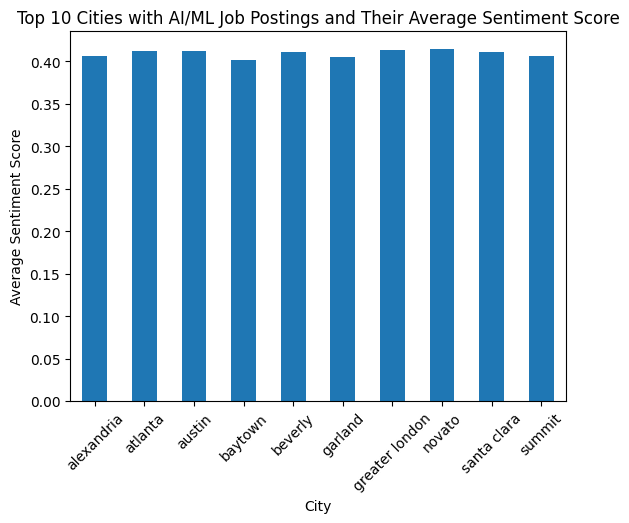

In [15]:
top_cities = ai_ml_jobs_analysed['search_city'].value_counts().head(10).index
city_sentiment = ai_ml_jobs_analysed[ai_ml_jobs_analysed['search_city'].isin(top_cities)].groupby('search_city')['sentiment_score'].mean()

city_sentiment.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Average Sentiment Score')
plt.title('Top 10 Cities with AI/ML Job Postings and Their Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

## Contextual Skill Analysis Using BERT

AI/ML Keywords

In [16]:
ai_ml_terms = """
artificial intelligence, machine learning, deep learning, neural networks, computer vision, natural language processing, large language model, reinforcement learning, supervised learning, unsupervised learning, semi-supervised learning, transfer learning, predictive modeling, classification, regression, clustering, convolutional neural networks, cnn, rnn, long short-term memory, lstm, gan, generative adversarial networks, support vector machine, svm, random forests, decision trees, ensemble learning, feature engineering, feature selection, data preprocessing, data mining, big data, data science, data analysis, data visualization, sentiment analysis, chatbots, speech recognition, image recognition, object detection, time series analysis, recommender systems, autonomous systems, robotics, chatbot development, nlp algorithms, tensorFlow, keras, pytorch, scikit-learn, openai, machine learning algorithms, model training, model evaluation
"""

ai_ml_frameworks = """
Python, R, Julia, SQL, Apache Spark, Databricks, Jupyter Notebook, Google Cloud AI Platform, Amazon SageMaker, Microsoft Azure Machine Learning, Docker, Kubernetes, Git, GitHub, Anaconda, Weights & Biases, MLflow, Apache Kafka, Airflow, Tableau, Power BI, Looker, MATLAB, Scala, C++, Java, PySpark, Databricks, Snowflake, BigQuery, Vertex AI, OpenCV, NLTK, spaCy, Gensim, Hugging Face Transformers, Ray, Dask, Kedro, DVC (Data Version Control), Great Expectations, Kedro, Weights & Biases, Streamlit, FastAPI, Dash, Flask, XGBoost, LightGBM
"""

ai_ml_acronyms = """
RAG, LLM, GenAI, ML, DL, NLP, CV, RL, GAN, CNN, RNN, LSTM, SVM, SAA, AGI, AIoT, HCI, TF, PyTorch, KNN, SVD, BERT, GPT, T5, VAE, BIM, BOM, IoT, CICD, MLOps, AI/ML, API, RPA, ETL, DNN, RNN, BFS, AIaaS, MLaaS, DLaaS, Jupyter, K8s, EDA, RNN, BERT, VQA, CVPR, MT, FL, AI-ML, Keras, XLNet
"""

ai_terms_list = [item.strip() for item in ai_ml_terms.split(",")]
ai_ml_frameworks_list = [item.strip() for item in ai_ml_frameworks.split(",")]
ai_acronyms_list = [item.strip() for item in ai_ml_acronyms.split(",")]

ai_ml_keywords = set(ai_terms_list + ai_ml_frameworks_list + ai_acronyms_list)

print(f"Number of AI/ML keywords: {len(ai_ml_keywords)}")


Number of AI/ML keywords: 150


BERT Model params

In [17]:
ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=tokenizer)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


Extract skills and their contexts using BERT-based NER.

In [18]:
def extract_skill_context_bert(text, keywords):
    entities = ner_pipeline(text)
    skill_contexts = []

    for entity in entities:
        if entity['word'].lower() in keywords:
            skill_contexts.append({
                "skill": entity['word'],
                "entity_type": entity['entity'],
                "context": text[max(0, entity['start'] - 30):entity['end'] + 30]
            })

    return skill_contexts

def add_skill_context_bert(df, keywords):
    df = df.copy()
    combined_text = df.apply(lambda row: combine_row_text(row), axis=1)
    skill_contexts = []
    for desc in tqdm(combined_text, desc="Extracting Skill Contexts"):
        contexts = extract_skill_context_bert(desc, keywords)
        skill_contexts.append(contexts)
    df['skill_contexts'] = skill_contexts
    return df

In [19]:
keywords = [keyword.lower() for keyword in ai_ml_keywords]
ai_ml_jobs_with_contexts = add_skill_context_bert(ai_ml_jobs, keywords)

Extracting Skill Contexts: 100%|██████████| 62621/62621 [36:14<00:00, 28.79it/s]  


In [28]:
ai_ml_jobs_with_contexts.sample(5)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,keyword_count,keyword_likelihood,skill_contexts
94128,2024-01-19 17:32:14.268172+00,t,t,f,global supervisor of vendor management,r.r. donneley,"phoenix, az",2024-01-14,canyon,united states,vendor,mid senior,onsite,"[vendor management, contract management, subsc...",26,2,1,[]
395260,2024-01-19 09:45:09.215838+00,t,t,f,"economics analyst, natural resources",icf,"reston, va",2024-01-13,alexandria,united states,economist,mid senior,onsite,"[economics, public policy, environmental scien...",38,4,2,[]
264948,2024-01-19 09:45:09.215838+00,t,t,f,software engineering lead,dice,"reading, pa",2024-01-12,exeter,united states,agricultural-research engineer,mid senior,onsite,"[java, rpg, react, angular, jquery, html, java...",29,2,1,[]
157064,2024-01-19 23:09:36.910064+00,t,t,f,first year tax professional,h&r block,"gladstone, or",2024-01-14,oregon,united states,tax preparer,mid senior,onsite,"[tax interviews, tax returns preparation, busi...",24,2,1,[]
198999,2024-01-19 09:45:09.215838+00,t,t,f,cloud support engineer i - bigdata,amazon web services (aws),"toronto, ontario, canada",2024-01-13,sarnia-clearwater,canada,data base administrator,associate,onsite,"[cloud technologies, aws products, amazon auro...",32,3,2,[]


Save analysed jobs

In [21]:
filename_analysed_ctx = "data/c_job_postings_ai_ml_analysed_ctx.parquet"
ai_ml_jobs_with_contexts.to_parquet(filename_analysed_ctx)